In [1]:
## Install required packages (NB: they may already be installed on your machine)
# install.packages("tidyverse")
# install.packages("infer")
# install.packages("janitor")
# install.packages("repr")
# install.packages("stringr")
# install.packages("waffle", repos = "https://cinc.rud.is")
# install.packages("plyr")
# install.packages("ggthemes")

## Waffle is sometimes finicky, so you might also need this
# remotes::install_github("hrbrmstr/waffle")

In [2]:
# Load required packages
library(plyr)
library(tidyverse)
library(infer)
library(janitor)
library(repr)
library(stringr)
library(waffle)
library(ggthemes)

-- Attaching packages ----------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts -------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::arrange()   masks plyr::arrange()
x purrr::compact()   masks plyr::compact()
x dplyr::count()     masks plyr::count()
x dplyr::failwith()  masks plyr::failwith()
x dplyr::filter()    masks stats::filter()
x dplyr::id()        masks plyr::id()
x dplyr::lag()       masks stats::lag()
x dplyr::mutate()    masks plyr::mutate()
x dplyr::rename()    masks plyr::rename()
x dplyr::summarise() masks plyr::summarise()
x dplyr::summarize() masks plyr::summarize()


Attaching package: 'janitor'


The following objects

In [3]:
# Custom ggplot theme for use throughout the analysis
# Idea from [Joey Stanley](https://joeystanley.com/blog/custom-themes-in-ggplot2)

theme_stat201 <- function (width = 12, height = 5) { 
    options(repr.plot.width = width, repr.plot.height = height)
    theme_bw(base_size = 14) %+replace% 
        theme(
            plot.title = element_text(hjust = 0.5) 
        )
}

# Examining the Impact of COVID-19 on the Proportion of Theft-Related Crimes in Metro Vancouver

Group 4, Project Proposal (Acky Xu, Adam Mitha, Icy Xu, Michael DeMarco)

**Abstract**
This project looks at the impact of the COVID-19 pandemic on theft-related crime in select Metro Vancouver neighborhoods. Novel inferential techniques are applied to estimate the proportion of theft crime relative to all crime between now (2020) and the mean proportion of the past 3 years (2017 to 2019). Our findings are still to be  determined, and will be included in the final report.

![A VPD car](./images/vpd.jpg)

<p style="text-align: center;"><i>A Vancouver Police Department (VPD) car.</i></p>

## Introduction

### Background 

Since the beginning of the COVID-19 pandemic in March of 2020, many have discussed the issue of alleged increasing crime rates both globally and within Metro Vancouver. Indeed, an unprecedented economic contraction coupled with fewer resources, such as shelters or food banks, has driven increase in property-related crimes [source?]. In addition, hate crimes have more than doubled [source?], with those of East Asian descent being impacted most significantly.

These issues have led to significant tension between municipal governments and police departments [source?] with respect to budgeting in the wake of the economic depravity of the COVID-19 era.

TODO: add in literature, talk about petty crime

### Question

We are interested in exploring how much, if at all, crime rates have increased in Metro Vancouver over the last year. We will compare crime rates from 2017 to 2020 in neighborhoods characteristic of the full economic spectrum to assess if the COVID-19 has impacted crime rates locally in Vancouver.

Therefore, our research question is as follows: _"Has crime rate indeed actually increased in Metro Vancouver by a significant amount in 2020, across various rungs of the economic ladder?"_

TODO: change question, add in petty crime; add in literature

### Data set

We will be using the Vancouver Police Department's Open Crime Data to answer our research question.

Our random variable of interest is the proportion of theft-related crime with respect to all crime. We will be studying the change of this value from 2017 to 2020 across three different Vancouver neighbors, each characteristic of a different level of wealth. Thus, our location parameter is a proportion, and we will be studying the spread in our value through standard deviation, since this can be computed directly from the proportion.

## Preliminary Results

We'll start by importing the dataset from it's [original source](https://geodash.vpd.ca/opendata), loading it into a dataframe and inspecting the results.

In [4]:
# Download the file to wherever your Jupyter notebook is located
url <- "https://geodash.vpd.ca/opendata/crimedata_download/crimedata_csv_all_years.zip"
filename <- "crime_data.zip"
download.file(url, destfile = filename)

# Data comes in as a zip, so we'll need to extract it
unzip("crime_data.zip")

# Read in the desired file
crime_data <- read_csv("crimedata_csv_all_years.csv")


-- Column specification ----------------------------------------------------------------------------------------------------------------------------------------------
cols(
  TYPE = col_character(),
  YEAR = col_double(),
  MONTH = col_double(),
  DAY = col_double(),
  HOUR = col_double(),
  MINUTE = col_double(),
  HUNDRED_BLOCK = col_character(),
  NEIGHBOURHOOD = col_character(),
  X = col_double(),
  Y = col_double()
)




In [5]:
# Inspect the first and last three rows of the data frame
head(crime_data, n = 3)
tail(crime_data, n = 3)

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2012,12,14,8,52,NA,Oakridge,491285.0,5453433
Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174


TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Vehicle Collision or Pedestrian Struck (with Injury),2016,6,20,18,11,YUKON ST / W KING EDWARD AVE,Riley Park,491786,5455143
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,3,9,49,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,27,14,40,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126


Our data largely comes in a "tidy" format already. By tidy, we're verifying (from the DSCI 100 course textbook, verbatim, which in turn is from Wickham and others, 2014): 
* each row is a single observation,
* each column is a single variable, and
* each value is a single cell

However, there are four steps we could take to improve the data set for our use: 
1. clean up the column names,
2. remove N/As,
3. select only data relevant to our analysis, and
4. convert crime types and neighborhoods to a factor, since we're working with proportions (i.e., categorical data).

We're primarily interested in the year, type and neighborhood of crimes, so we'll extract those columns and discard the rest. In addition, we would like to focus on year 2017-2020.

In [6]:
# 1. Generally, in R, you don't see ALL CAPS column names,
# so we can modify the column names manually (with the help)
# of the janitor library

crime_data <- crime_data %>% clean_names()
head(crime_data)

Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00C4>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00D6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00DC>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00E4>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00F6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00FC>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00DF>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00C6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00E6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00D8>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00F8>' to native encoding"
Warning message in FU

type,year,month,day,hour,minute,hundred_block,neighbourhood,x,y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2012,12,14,8,52,NA,Oakridge,491285.0,5453433
Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9,5459166
Break and Enter Commercial,2005,11,14,3,9,10XX ALBERNI ST,West End,491021.4,5459161


In [7]:
# 2. Remove all NAs (Note: na.omit(...) applies to the entire data frame, 
# but neighbourhood is used as an example)

total_rows <- crime_data %>% nrow()
print(sprintf("There are %d rows in the data frame", total_rows))

na_neighbourhoods <- sum(is.na(crime_data$neighbourhood))
print(sprintf("Originally, there were %d NA values in the neighbourhood column", na_neighbourhoods))

crime_data <- na.omit(crime_data)

na_neighbourhoods <- sum(is.na(crime_data$neighbourhood))
print(sprintf("Now, there are %d NA values in the neighbourhood column", na_neighbourhoods))

[1] "There are 666293 rows in the data frame"
[1] "Originally, there were 69872 NA values in the neighbourhood column"
[1] "Now, there are 0 NA values in the neighbourhood column"


In [8]:
# 3. Select only type, year, neighbourhood
# Filter to the data range of 2017-2020

crime_data <- crime_data %>% 
    select(type, year, neighbourhood) %>%
    filter(2017 <= year & year <= 2020)
head(crime_data)

type,year,neighbourhood
<chr>,<dbl>,<chr>
Break and Enter Commercial,2019,Fairview
Break and Enter Commercial,2019,West End
Break and Enter Commercial,2020,West End
Break and Enter Commercial,2017,West End
Break and Enter Commercial,2018,West End
Break and Enter Commercial,2020,West End


In [9]:
# 4. Now, we'll convert `neighbourhood` and `type` to a factor, 
# since we're considering it categorical data
crime_data <- crime_data %>%
    mutate(type = as_factor(type)) %>%
    mutate(neighbourhood = as_factor(neighbourhood))
head(crime_data)

type,year,neighbourhood
<fct>,<dbl>,<fct>
Break and Enter Commercial,2019,Fairview
Break and Enter Commercial,2019,West End
Break and Enter Commercial,2020,West End
Break and Enter Commercial,2017,West End
Break and Enter Commercial,2018,West End
Break and Enter Commercial,2020,West End


Next, let's see how many different types of crimes there are present in our data set.

In [10]:
# Grab all unique crime types, and print them in a pretty way
crime_types <- unique(crime_data$type)
print(crime_types)

[1] Break and Enter Commercial                            
[2] Break and Enter Residential/Other                     
[3] Mischief                                              
[4] Other Theft                                           
[5] Theft from Vehicle                                    
[6] Theft of Bicycle                                      
[7] Theft of Vehicle                                      
[8] Vehicle Collision or Pedestrian Struck (with Fatality)
[9] Vehicle Collision or Pedestrian Struck (with Injury)  
9 Levels: Break and Enter Commercial ... Vehicle Collision or Pedestrian Struck (with Injury)


As was mentioned in the introduction, we're interested in theft related crime. Let's create a list of all theft related crime we see in this data set.

In [11]:
theft_crimes <- c('Other Theft', 'Theft from Vehicle', 
                  'Theft of Bicycle', 'Theft of Vehicle')

We can also check the neighbourhoods present in this data set.

In [12]:
# Grab all unique crime types, and print them in a pretty way
neighbourhoods <- unique(crime_data$neighbourhood)
print(neighbourhoods)

 [1] Fairview                  West End                 
 [3] Central Business District Hastings-Sunrise         
 [5] Strathcona                Grandview-Woodland       
 [7] Mount Pleasant            Sunset                   
 [9] Kensington-Cedar Cottage  Stanley Park             
[11] Shaughnessy               Marpole                  
[13] Oakridge                  Kitsilano                
[15] Victoria-Fraserview       Kerrisdale               
[17] West Point Grey           Riley Park               
[19] Arbutus Ridge             Renfrew-Collingwood      
[21] Killarney                 South Cambie             
[23] Dunbar-Southlands         Musqueam                 
24 Levels: Fairview West End Central Business District ... Musqueam


We chosen three neighborhoods that we believe are representative of different economic classes present in Vancouver, in terms of median wealth: Shaughnessy, Strathcona, and Marpole. Let's save those as well.

In [13]:
chosen_neighbourhoods <- c("Shaughnessy", "Strathcona", "Marpole")

We're hoping to compare crime rates across years in neighborhoods that represent a reasonable distribution of incomes. For our proposal, we're going to be using the Shaughnessy, Strathcona, and Marpole neighborhoods. More on why these neighborhoods were chosen in particular is discussed in the methods section.

In [14]:
# Filter down by the 3 neighbourhoods above
crime_data <- crime_data %>%
    filter(neighbourhood %in% chosen_neighbourhoods)

head(crime_data, n = 3)
tail(crime_data, n = 3)

type,year,neighbourhood
<fct>,<dbl>,<fct>
Break and Enter Commercial,2017,Strathcona
Break and Enter Commercial,2020,Strathcona
Break and Enter Commercial,2020,Strathcona


type,year,neighbourhood
<fct>,<dbl>,<fct>
Vehicle Collision or Pedestrian Struck (with Injury),2018,Strathcona
Vehicle Collision or Pedestrian Struck (with Injury),2018,Marpole
Vehicle Collision or Pedestrian Struck (with Injury),2018,Marpole


Now, to get a better sense of our data set, we'll produce three plots to explore, at a high level, what crime looks like in Vancouver both over time and by neighborhood. Our three plots will be:

1. A line plot of total crime over time, grouped by neighborhood
2. A stacked bar chart showing a break down of crime type, grouped by neighborhood
3. A waffle plot to show to crime types proportions, grouped by year

Let's begin with the line plot.

In [15]:
# To produce our line plot, first, we'll need to compute the total amount of crime
# by neighborhood and yea
neighbourhood_year_counts <- crime_data %>%
    group_by(neighbourhood, year) %>% 
    summarise(number_of_crimes = n())
head(neighbourhood_year_counts)

`summarise()` has grouped output by 'neighbourhood'. You can override using the `.groups` argument.



neighbourhood,year,number_of_crimes
<fct>,<dbl>,<int>
Strathcona,2017,1772
Strathcona,2018,1986
Strathcona,2019,2168
Strathcona,2020,1708
Shaughnessy,2017,444
Shaughnessy,2018,414


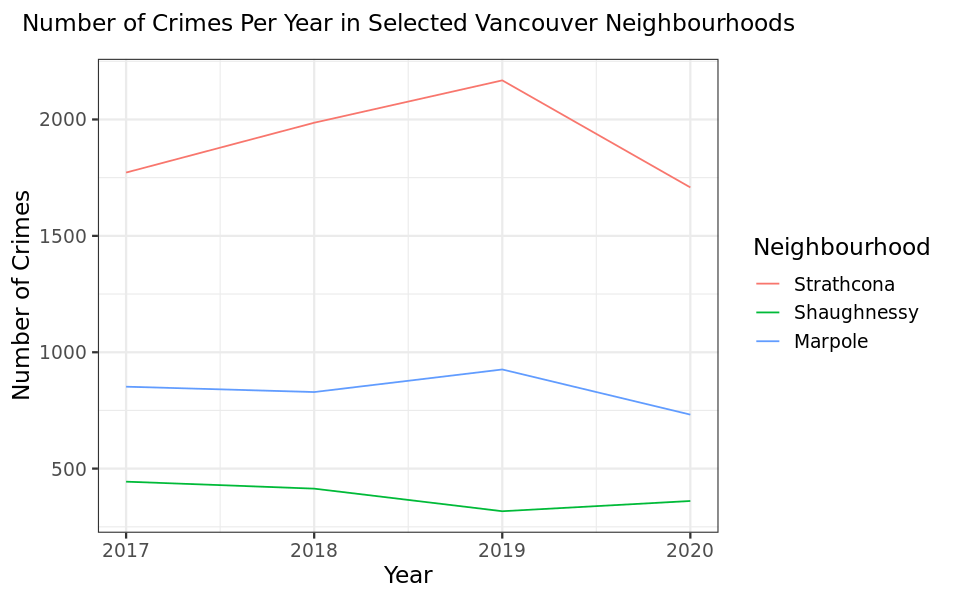

In [16]:
# 1. Finally, let's plot our data
crime_data_plot <- neighbourhood_year_counts %>%
    ggplot() +
    geom_line(aes(x = year, y = number_of_crimes, color = neighbourhood)) +
    scale_x_continuous(limits = c(2017, 2020)) +
    labs(x = "Year", y = "Number of Crimes", color = "Neighbourhood") +
    ggtitle("Number of Crimes Per Year in Selected Vancouver Neighbourhoods\n") +
    theme_stat201(8, 5)
crime_data_plot

It's clear that the crime is highest in Strathcona, followed by Marpole, and then Shaughnessy. Crime has also generally decreased in 2020, especially in Strathcona. 

Alongside checking the number of crimes total in each neighborhood, it's also worth looking at how much of each type of crime is represented in our data set. Let's now look at the stacked bar chart.

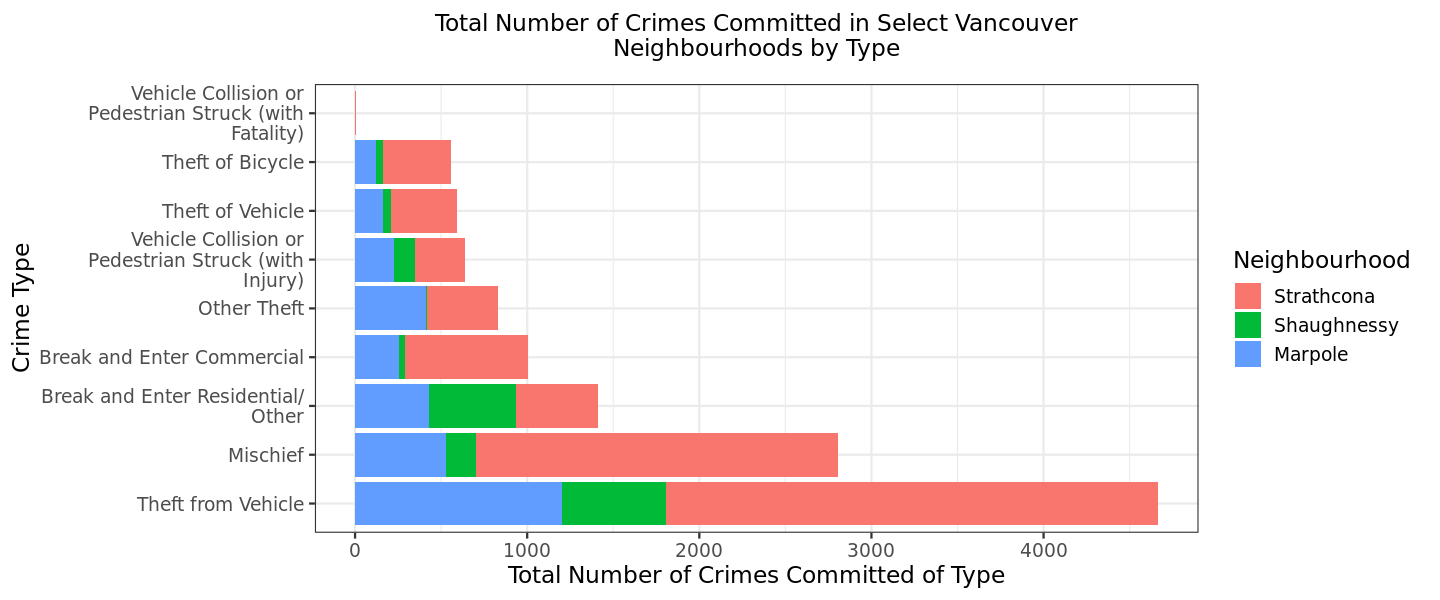

In [17]:
# 2. Note that the stringr::str_wrap call wraps the long label names for crime types, and
# reorder places the largest crime count on the bottom
crime_type_bar_plot <- crime_data %>%
    ggplot(aes(x = reorder(str_wrap(type, 30), type, function(x) - length(x)), fill = neighbourhood)) +
    geom_bar(position = "stack") +
    labs(x = "Crime Type", y = "Total Number of Crimes Committed of Type", fill = "Neighbourhood") +
    ggtitle("Total Number of Crimes Committed in Select Vancouver\nNeighbourhoods by Type\n") +
    coord_flip() +
    theme_stat201()

# Vehicle collisions that result in fatality are (thankfully) very low,
# and almost distinguishable on the plot below                           
crime_type_bar_plot

This plot shows that theft from vehicle, in the Strathcona region, makes up a large proportion of all crimes committed. We can also see, thankfully, that vehicle collisions resulting in fatality make up such a small fraction of our data they're hard to distinguish.

Finally, we can look at a visualization of the relative frequencies of crime over the years through a waffle chart. Note that each individual square represents 30 items.

In [18]:
# Let's produce a count of the crime by year and type
crime_waffle <- crime_data %>%
    count(year, type) %>%
    mutate(n = n / 30)
head(crime_waffle)

year,type,n
<dbl>,<fct>,<dbl>
2017,Break and Enter Commercial,7.233333
2017,Break and Enter Residential/Other,11.500000
2017,Mischief,21.500000
2017,Other Theft,7.433333
2017,Theft from Vehicle,37.700000
2017,Theft of Bicycle,4.466667


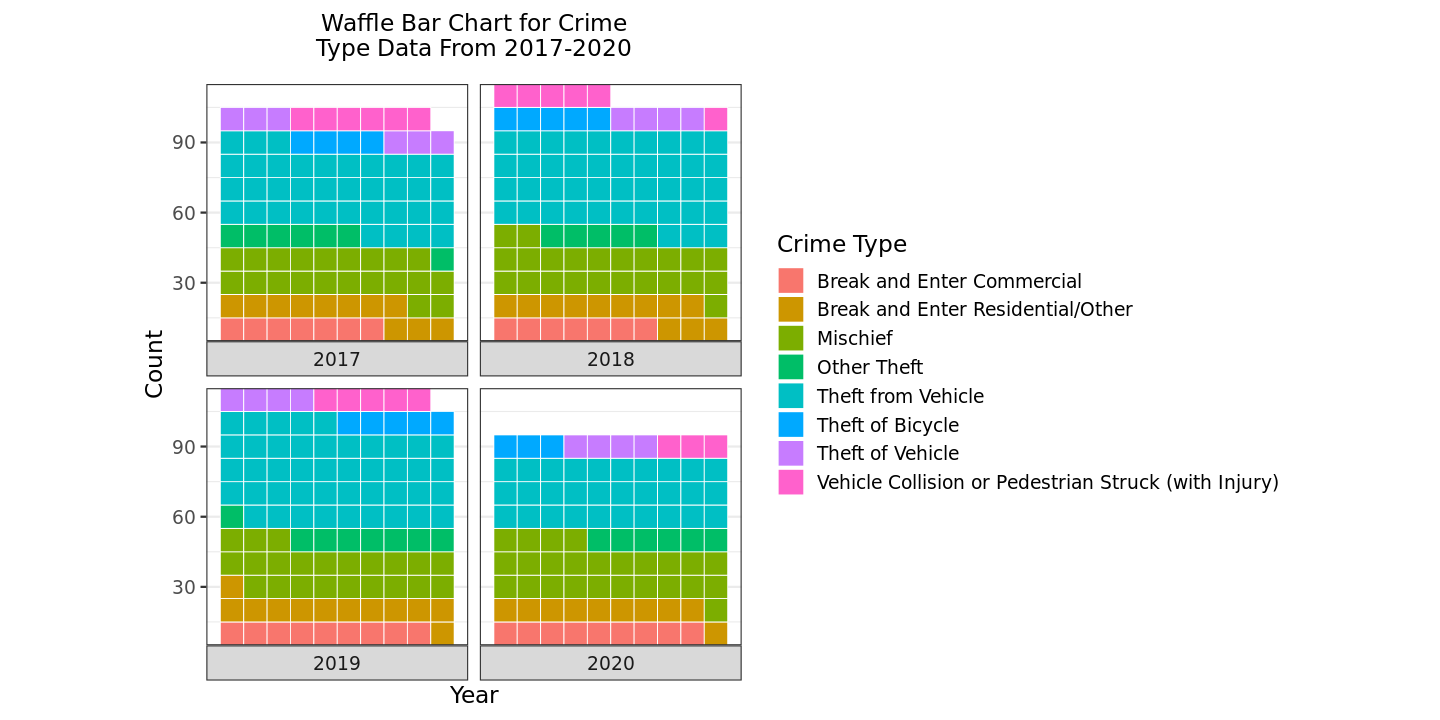

In [19]:
# 3. Let's look at the proportion of each crime committed over the years
waffle_plot <- crime_waffle %>%
    ggplot(aes(values = n, fill = type)) +
    geom_waffle(n_rows = 10, flip = TRUE, color = "white", size = 0.25) +
    facet_wrap(~year, nrow = 2, strip.position = "bottom") +
    scale_x_discrete() + 
    scale_y_continuous(labels = function(x) x * 10, # make this multiplyer the same as n_rows
                       expand = c(0,0)) +
    labs(
        title = "Waffle Bar Chart for Crime\nType Data From 2017-2020\n",
        # subtitle = "A single square represents 30 crimes",
        x = "Year",
        y = "Count",
        fill = "Crime Type"
    ) +
    coord_equal() +
    theme_enhance_waffle() +
    theme(legend.position = "bottom") +
    theme_stat201(12, 6)
waffle_plot

Now, we can compute estimates of our parameter of interest across each of our different groups. In our case, this means computing the difference between the  mean of proportion of theft crimes committed across 2017-19 and the proportion of theft crimes comitted in 2020.

In [20]:
# Let's first compute the pre-COVID mean in each neighbourhood (merging 2017 to 2019)
before_pandemic_df_by_year <- crime_data %>%
    mutate(is_theft = as.numeric(type %in% theft_crimes)) %>%
    filter(year >= 2017 & year <= 2019) %>%
    group_by(neighbourhood, year) %>%
    summarize(prop_theft = sum(is_theft) / n())
# View prop_theft by year (2017, 2018, 2019) and neighbourhood
# head(p_hat_pre_covid_by_year)

before_pandemic_df <- before_pandemic_df_by_year %>%
    group_by(neighbourhood) %>%
    summarize(prop_theft = mean(prop_theft)) %>%
    mutate(time = "Before pandemic") %>%
    mutate(time = as_factor(time))
head(before_pandemic_df)

`summarise()` has grouped output by 'neighbourhood'. You can override using the `.groups` argument.



neighbourhood,prop_theft,time
<fct>,<dbl>,<fct>
Strathcona,0.5578307,Before pandemic
Shaughnessy,0.4624363,Before pandemic
Marpole,0.5675852,Before pandemic


In [21]:
# Now let's get an estimate for the COVID mean by neighbourhood
during_pandemic_df <- crime_data %>%
    mutate(is_theft = as.numeric(type %in% theft_crimes)) %>%
    filter(year == 2020) %>%
    group_by(neighbourhood) %>%
    summarize(prop_theft = sum(is_theft) / n()) %>%
    mutate(time = "During pandemic") %>%
    mutate(time = as_factor(time))
head(during_pandemic_df)

neighbourhood,prop_theft,time
<fct>,<dbl>,<fct>
Strathcona,0.4385246,During pandemic
Shaughnessy,0.4349030,During pandemic
Marpole,0.5655738,During pandemic


In [22]:
# Summarize in table
combined_tibble <- during_pandemic_df %>%
    rename(during_prop_theft = prop_theft) %>%
    select(during_prop_theft) %>%
    cbind(before_pandemic_df) %>%
    mutate(prop_diff = during_prop_theft - prop_theft) %>%
    select(neighbourhood, prop_diff)
head(combined_tibble)

,neighbourhood,prop_diff
,<fct>,<dbl>
1,Strathcona,-0.119306097
2,Shaughnessy,-0.027533295
3,Marpole,-0.002011429


Our initial data suggests that the proportion of theft-related crime has actually _decreased_ since the pandemic began. While this is a good estimate for us to begin our analysis with, it's by no means sufficient to conclude upon; more as to why that is is discussed below.

## Methods

We will retrieve Vancouver Police Force's crime data from the link below:
http://geodash.vpd.ca/opendata/crimedata_download/crimedata_csv_all_years.zip?disclaimer=on&x=101&y=21

Inside the zip file, there is a CSV file call 'crimedata_csv_all_years.csv' with the following headers:

- YEAR
- MONTH
- DAY
- HOUR
- MINUTE
- HUNDRED_BLOCK
- NEIGHBOURHOOD
- X
- Y

To narrow the scope of our project, we will focus on these neighbourhoods and run individual analysis on the crime rate of those neighbourhood:

- Strathcona
- Shaughnessy
- Marpole
- (Try to get a good spread of wealth of neighbourhood, since VPD bases their subdivision according to Stats Canada Census Division, we can use that to base our focus neighbourhoods)

Since we have the population of all crime reported in Vancouver, we will create a sampling distribution for 2020 and combination of 2019, 2018, and 2017(maybe? see if we need to do bootstrap.  If so, we can draw a sampel form the data set of the neighbourhood we are interested in and go form there).

Using our distribution, we will find the proportion of theft-related crime in 2017-2019 to use as our null hypothesis of what the crime rate in 2020 should be.

Then we will run our analysis to see if there is a significant change in crime rate in 2020 (either increase or decrease) for our hypothesis testing.

## Reflection

In our final report, we expect to find [...]

We anticipate the impact of our findings will be [...]

Three examples of further questions that could extend this analysis are:

1. item 1
2. item 2
3. item 3

## References

Existing literature exists for organized crime

Wikipedia

https://en.wikipedia.org/wiki/Impact_of_the_COVID-19_pandemic_on_crime#cite_note-32

Organized crime up

https://globalinitiative.net/wp-content/uploads/2020/03/GI-TOC-Crime-and-Contagion-The-impact-of-a-pandemic-on-organized-crime.pdf

Murder rates down

https://www.nytimes.com/2020/04/11/world/americas/coronavirus-murder-latin-america-crime.html

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7338127/

https://www.cbc.ca/news/canada/british-columbia/crime-statistics-vancouver-2020-1.5779400

https://www.osac.gov/Country/Canada/Content/Detail/Report/fd184899-ac3b-4e43-a31b-18f82fda35c4

https://bc.ctvnews.ca/hate-crimes-up-97-overall-in-vancouver-last-year-anti-asian-hate-crimes-up-717-1.5314307

https://www.cbc.ca/news/canada/british-columbia/city-of-vancouver-freezes-police-department-funding-as-part-of-2021-budget-1.5833731

In [ ]:
# Delete unzipped files, and the zip archive
unlink("*.csv")
unlink("*.txt")
unlink("*.pdf")
unlink("*.zip")